# 5153 - Final Project: Sign Language Prediction

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

Tensorflow V2.11.0
Keras V2.11.0
Python V3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


# Plot Config

In [2]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Config

In [3]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = True

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 12
NUM_CLASSES = 250
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
VERBOSE = 1 if IS_INTERACTIVE else 2

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 3
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05

# Utils

In [4]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

# Train

In [5]:
# Read Training Data
if IS_INTERACTIVE or not PREPROCESS_DATA:
    train = pd.read_csv('/kaggle/input/asl-signs/train.csv').sample(int(5e3), random_state=SEED)
else:
    train = pd.read_csv('/kaggle/input/asl-signs/train.csv')

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 5000


# Add File Path

In [6]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-signs/{path}'

train['file_path'] = train['path'].apply(get_file_path)

# Ordinally Encode Sign

In [7]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [8]:
display(train.head(30))
display(train.info())

,path,participant_id,sequence_id,sign,file_path,sign_ord
38813,train_landmark_files/37779/2588297604.parquet,37779,2588297604,old,/kaggle/input/asl-signs/train_landmark_files/3...,159
89276,train_landmark_files/49445/783030079.parquet,49445,783030079,weus,/kaggle/input/asl-signs/train_landmark_files/4...,236
61482,train_landmark_files/37779/3520571668.parquet,37779,3520571668,shoe,/kaggle/input/asl-signs/train_landmark_files/3...,196
50093,train_landmark_files/34503/3049884955.parquet,34503,3049884955,kiss,/kaggle/input/asl-signs/train_landmark_files/3...,128
53927,train_landmark_files/26734/3207354789.parquet,26734,3207354789,fish,/kaggle/input/asl-signs/train_landmark_files/2...,84
24554,train_landmark_files/61333/2012019036.parquet,61333,2012019036,there,/kaggle/input/asl-signs/train_landmark_files/6...,216
31078,train_landmark_files/34503/2273965350.parquet,34503,2273965350,have,/kaggle/input/asl-signs/train_landmark_files/3...,108
83980,train_landmark_files/53618/568244381.parquet,53618,568244381,chair,/kaggle/input/asl-signs/train_landmark_files/5...,40
77013,train_landmark_files/53618/4152375783.parquet,53618,4152375783,mitten,/kaggle/input/asl-signs/train_landmark_files/5...,144
49104,train_landmark_files/36257/3007602041.parquet,36257,3007602041,morning,/kaggle/input/asl-signs/train_landmark_files/3...,147


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 38813 to 16216
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            5000 non-null   object
 1   participant_id  5000 non-null   int64 
 2   sequence_id     5000 non-null   int64 
 3   sign            5000 non-null   object
 4   file_path       5000 non-null   object
 5   sign_ord        5000 non-null   int16 
dtypes: int16(1), int64(2), object(3)
memory usage: 244.1+ KB


None

# Video Statistics

In [9]:
N = int(1e3) if (IS_INTERACTIVE or not PREPROCESS_DATA) else int(10e3)
N_UNIQUE_FRAMES = np.zeros(N, dtype=np.uint16)
N_MISSING_FRAMES = np.zeros(N, dtype=np.uint16)
MAX_FRAME = np.zeros(N, dtype=np.uint16)

PERCENTILES = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

for idx, file_path in enumerate(tqdm(train['file_path'].sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    N_UNIQUE_FRAMES[idx] = df['frame'].nunique()
    N_MISSING_FRAMES[idx] = (df['frame'].max() - df['frame'].min()) - df['frame'].nunique() + 1
    MAX_FRAME[idx] = df['frame'].max()

  0%|          | 0/1000 [00:00<?, ?it/s]

,N_UNIQUE_FRAMES
count,1000.000000
mean,38.102000
std,45.623164
min,2.000000
1%,6.000000
5%,6.000000
25%,11.000000
50%,22.000000
75%,43.000000
95%,139.050000


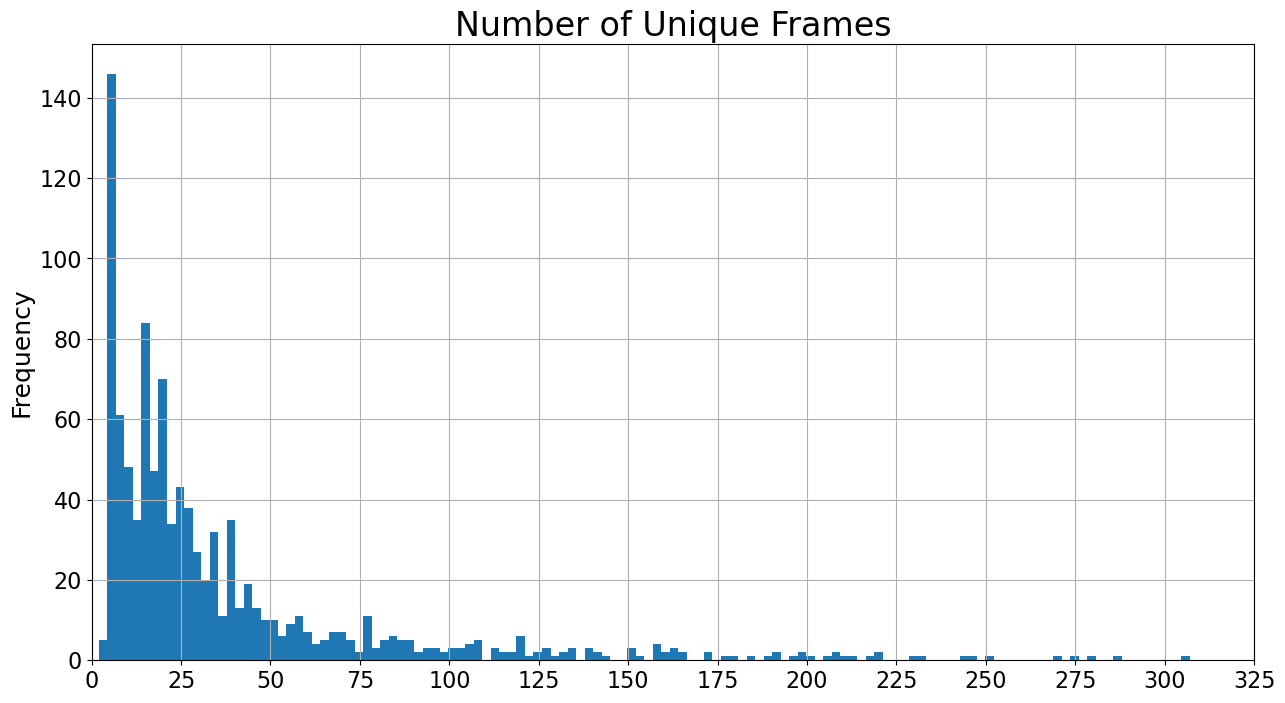

In [10]:
# Number of unique frames in each video
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_UNIQUE_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+25, 25))
plt.show()

,N_MISSING_FRAMES
count,1000.0
mean,0.0
std,0.0
min,0.0
1%,0.0
5%,0.0
25%,0.0
50%,0.0
75%,0.0
95%,0.0


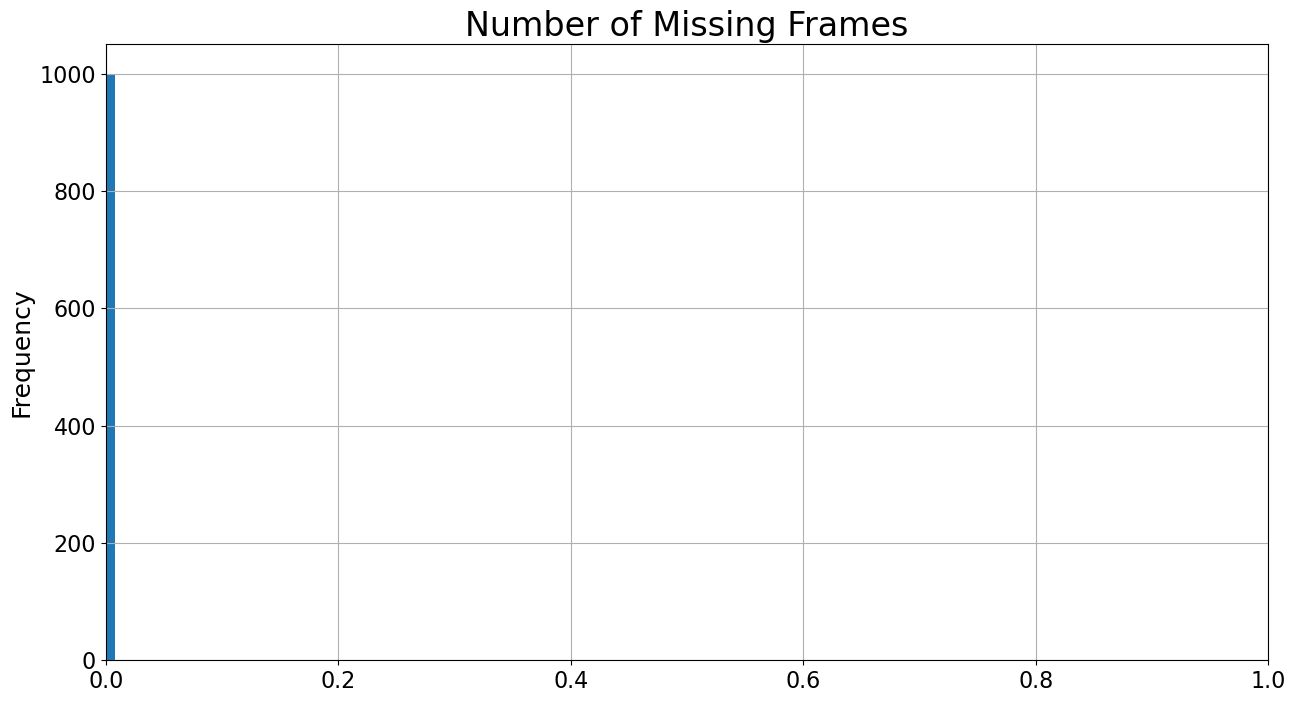

In [11]:
# Number of missing frames, consecutive frames with missing intermediate frame, i.e. 1,2,4,5 -> 3 is missing
display(pd.Series(N_MISSING_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_MISSING_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Missing Frames', size=24)
pd.Series(N_MISSING_FRAMES).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

,MAX_FRAME
count,1000.000000
mean,66.116000
std,59.956479
min,2.000000
1%,9.990000
5%,21.000000
25%,32.000000
50%,41.000000
75%,59.250000
95%,206.000000


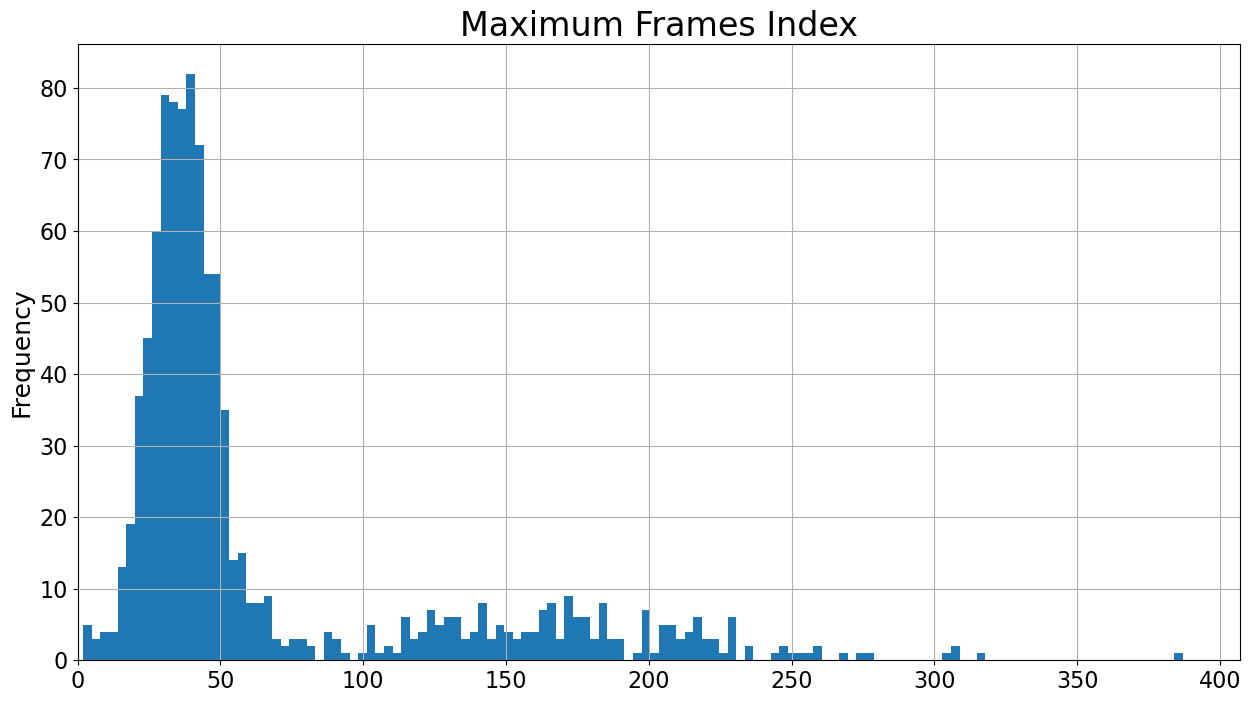

In [12]:
# Maximum frame number
display(pd.Series(MAX_FRAME).describe(percentiles=PERCENTILES).to_frame('MAX_FRAME'))

plt.figure(figsize=(15,8))
plt.title('Maximum Frames Index', size=24)
pd.Series(MAX_FRAME).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

# Landmark Indices

In [13]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [14]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


# Process Data Tensorflow

In [15]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [16]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

# Interpolate NaN Values

In [17]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

# Create Dataset

In [18]:
# Get the full dataset
def preprocess_data():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        # Log message every 5000 samples
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
    PARTICIPANT_IDS = train['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)
    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [19]:
# Preprocess All Data From Scratch
if PREPROCESS_DATA:
    preprocess_data()
    ROOT_DIR = '.'
else:
    ROOT_DIR = '/kaggle/input/gislr-dataset-public'
    
# Load Data
if USE_VAL:
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{ROOT_DIR}/X.npy')
    y_train = np.load(f'{ROOT_DIR}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Train 
print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

X_train shape: (80229, 64, 66, 3), dtype: float32
y_train shape: (80229,), dtype: int32
NON_EMPTY_FRAME_IDXS_TRAIN shape: (80229, 64), dtype: float32
X_val shape: (14248, 64, 66, 3), dtype: float32
y_val shape: (14248,), dtype: int32
NON_EMPTY_FRAME_IDXS_VAL shape: (14248, 64), dtype: float32
# NaN Values X_train: 0


In [20]:
# Class Count
display(pd.Series(y_train).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

,Class Count
135,358
136,352
60,351
194,351
67,348
170,277
249,267
56,266
21,263
231,255


# Number Of Frames

  0%|          | 0/64 [00:00<?, ?it/s]

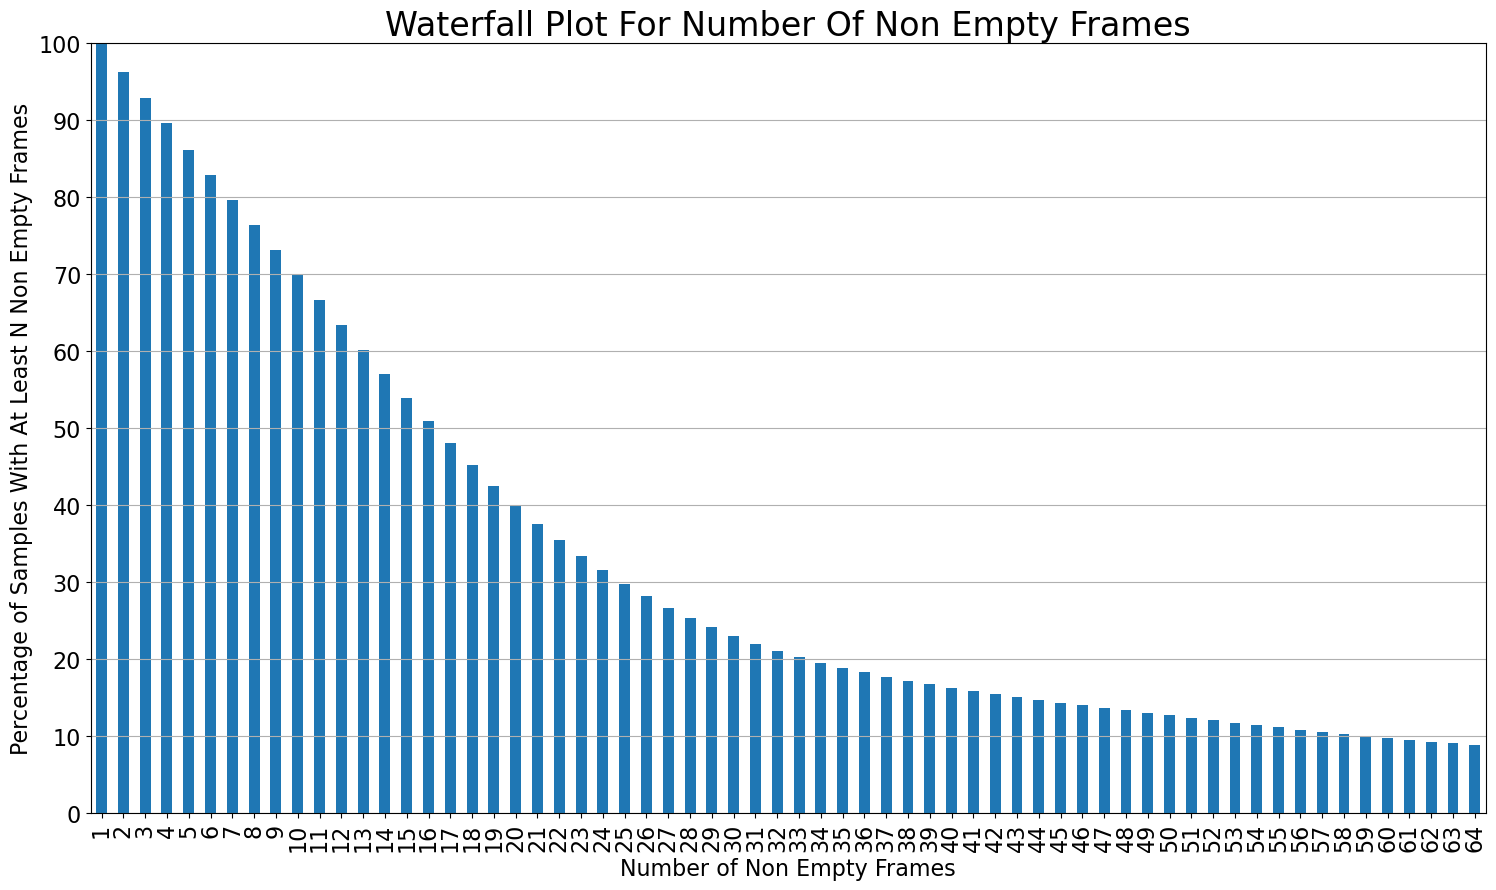

In [21]:
# Vast majority of samples fits has less than 32 non empty frames
N_EMPTY_FRAMES = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum(axis=1) 
N_EMPTY_FRAMES_WATERFALL = []
for n in tqdm(range(1,INPUT_SIZE+1)):
    N_EMPTY_FRAMES_WATERFALL.append(sum(N_EMPTY_FRAMES >= n) / len(NON_EMPTY_FRAME_IDXS_TRAIN) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Non Empty Frames')
pd.Series(N_EMPTY_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks(np.arange(INPUT_SIZE), np.arange(1, INPUT_SIZE+1))
plt.xlabel('Number of Non Empty Frames', size=16)
plt.yticks(np.arange(0, 100+10, 10))
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Non Empty Frames', size=16)
plt.show()

# Percentage of Frames Filled

In [22]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
print(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

P_DATA_FILLED: 33.59%


# Feature Statistics - Lips

In [23]:
# Percentage of Lips Measurements
P_LEFT_LIPS_MEASUREMENTS = (X_train[:,:,LIPS_IDXS] != 0).sum() / X_train[:,:,LIPS_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_LIPS_MEASUREMENTS: {P_LEFT_LIPS_MEASUREMENTS:.2f}%')

P_LEFT_LIPS_MEASUREMENTS: 99.34%


  0%|          | 0/40 [00:00<?, ?it/s]

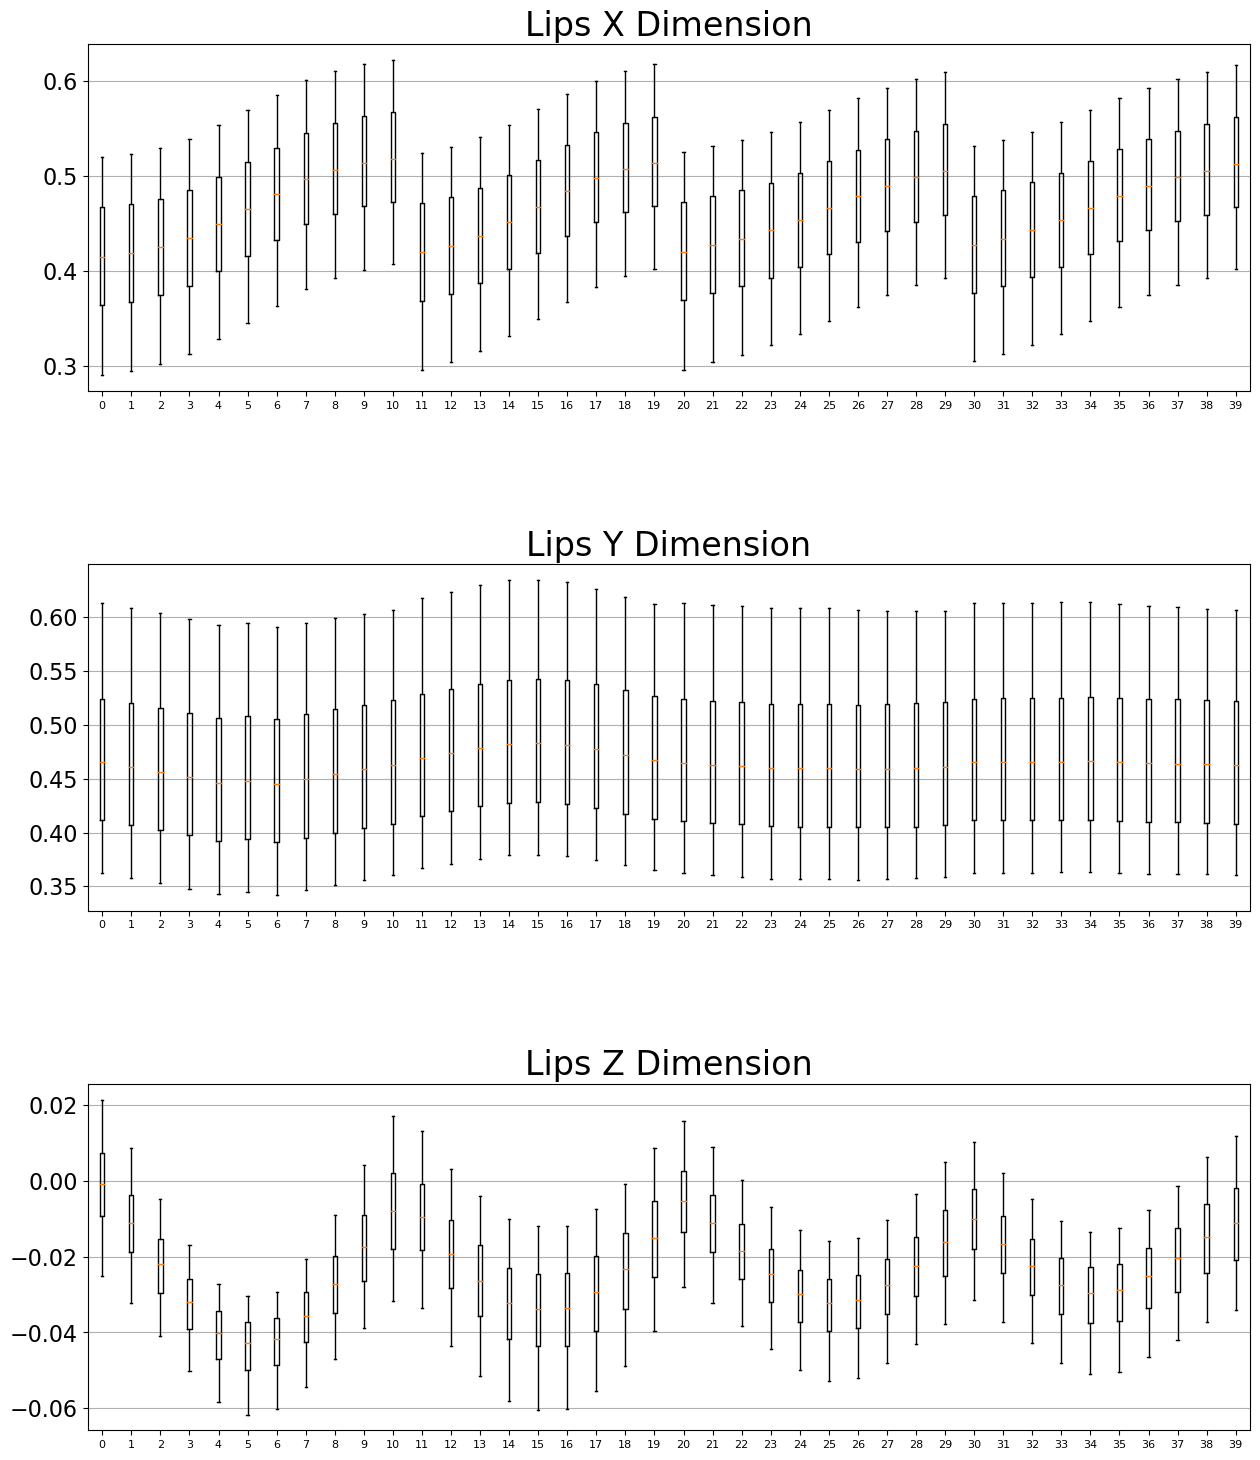

In [24]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

# Feature Statistics - Hands

In [25]:
# Verify Normalised to Left Hand Dominant
P_LEFT_HAND_MEASUREMENTS = (X_train[:,:,LEFT_HAND_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_HAND_MEASUREMENTS: {P_LEFT_HAND_MEASUREMENTS:.2f}%')

P_LEFT_HAND_MEASUREMENTS: 100.00%


  0%|          | 0/21 [00:00<?, ?it/s]

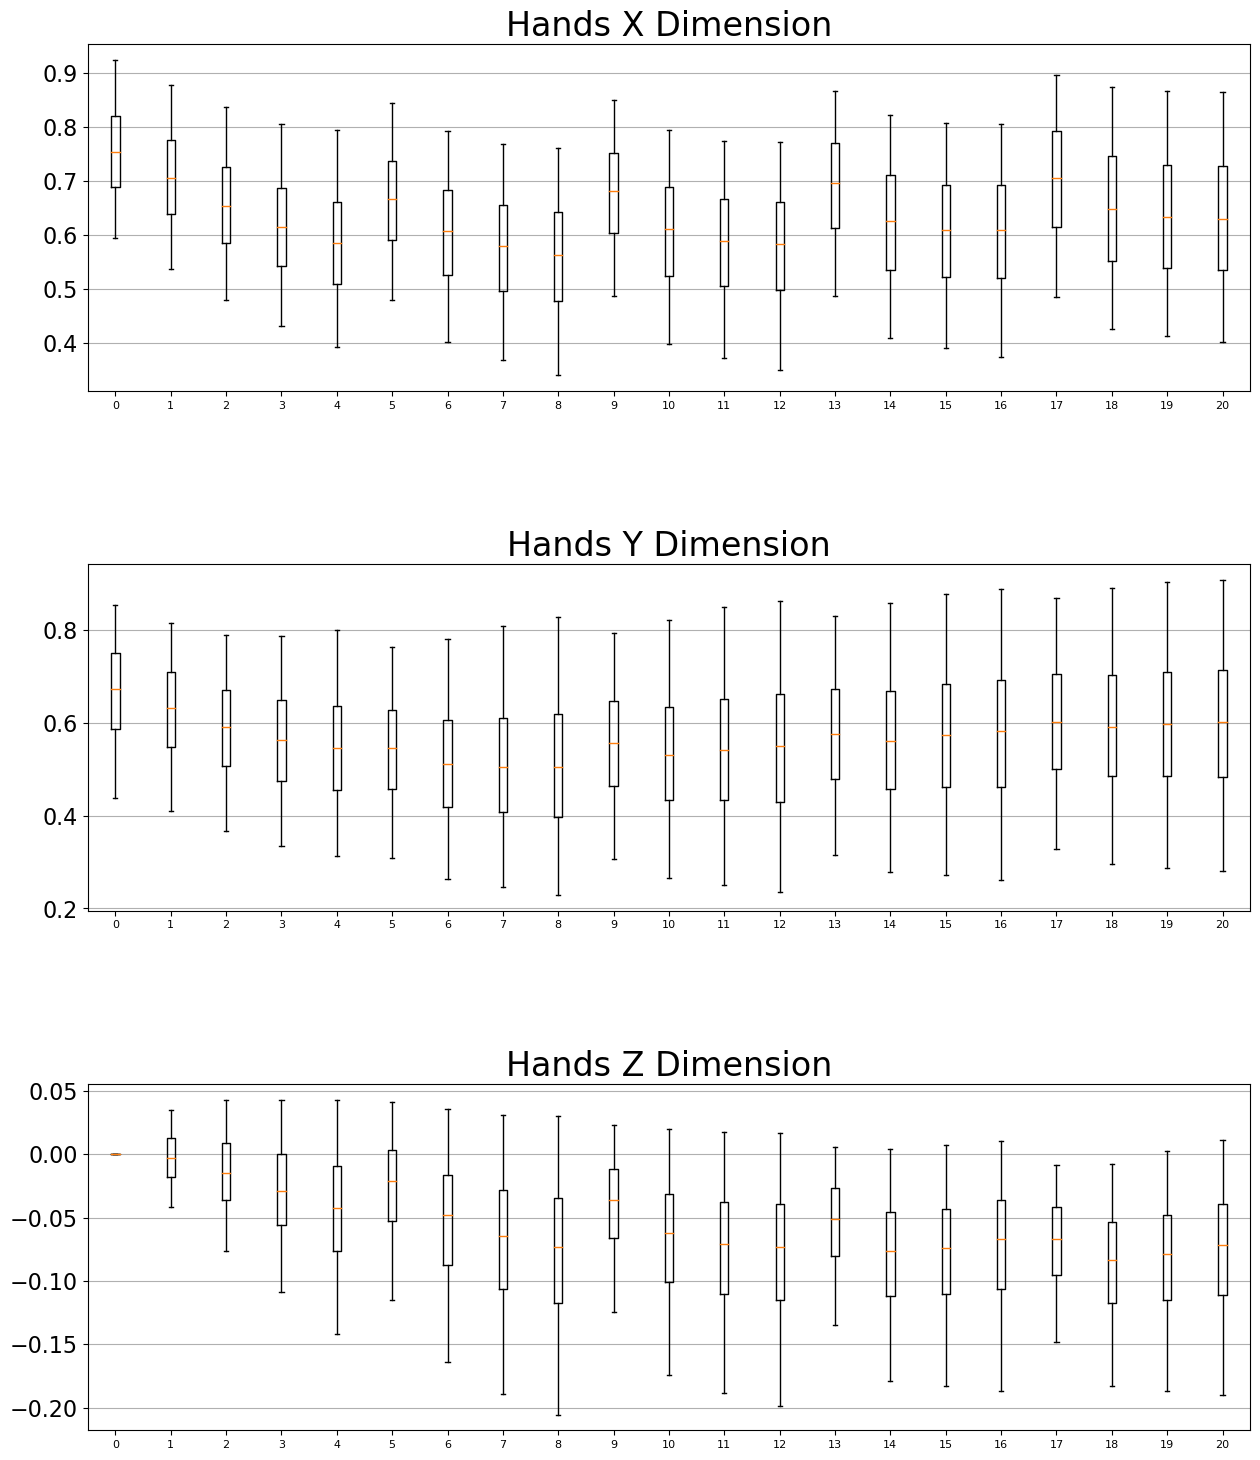

In [26]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

# Feature Statistics - Pose

In [27]:
# Percentage of Lips Measurements
P_POSE_MEASUREMENTS = (X_train[:,:,POSE_IDXS] != 0).sum() / X_train[:,:,POSE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_POSE_MEASUREMENTS: {P_POSE_MEASUREMENTS:.2f}%')

P_POSE_MEASUREMENTS: 100.00%


  0%|          | 0/5 [00:00<?, ?it/s]

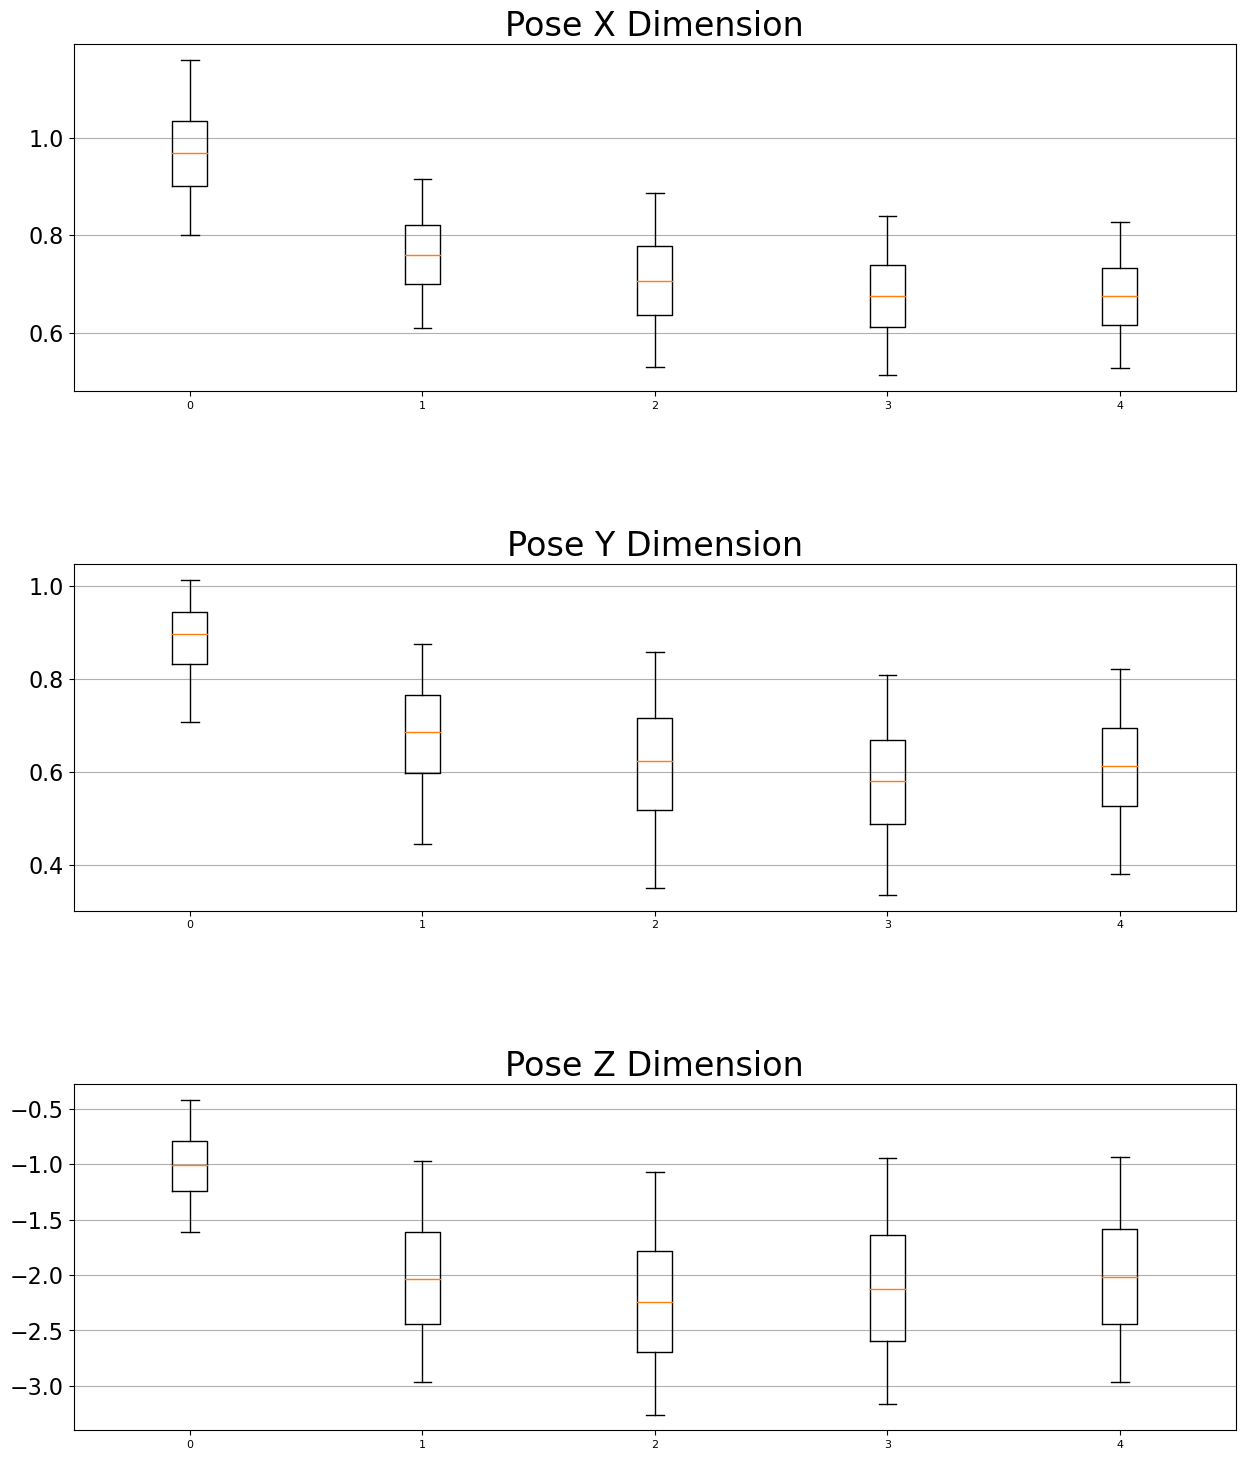

In [28]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

# Samples

In [29]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [30]:
dummy_dataset = get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (1000, 64, 66, 3), dtype: float32
non_empty_frame_idxs shape: (1000, 64), dtype: float32
y_batch shape: (1000,), dtype: int64


,Counts
0,4
171,4
158,4
159,4
160,4
...,...
88,4
89,4
90,4
91,4


# Model Config

In [31]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [32]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [33]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)
    
        return x

# Landmark Embedding

In [34]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [35]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

# Sparse Categorical Crossentropy With Label Smoothing

In [36]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smooth)

# Model

In [37]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )
    
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    
    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
        
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    label_smooth = 0.1
    loss = scce_with_ls
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=LR_MAX, weight_decay=1e-5, clipnorm=1.0)
    
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [38]:
tf.keras.backend.clear_session()

model = get_model()

In [39]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

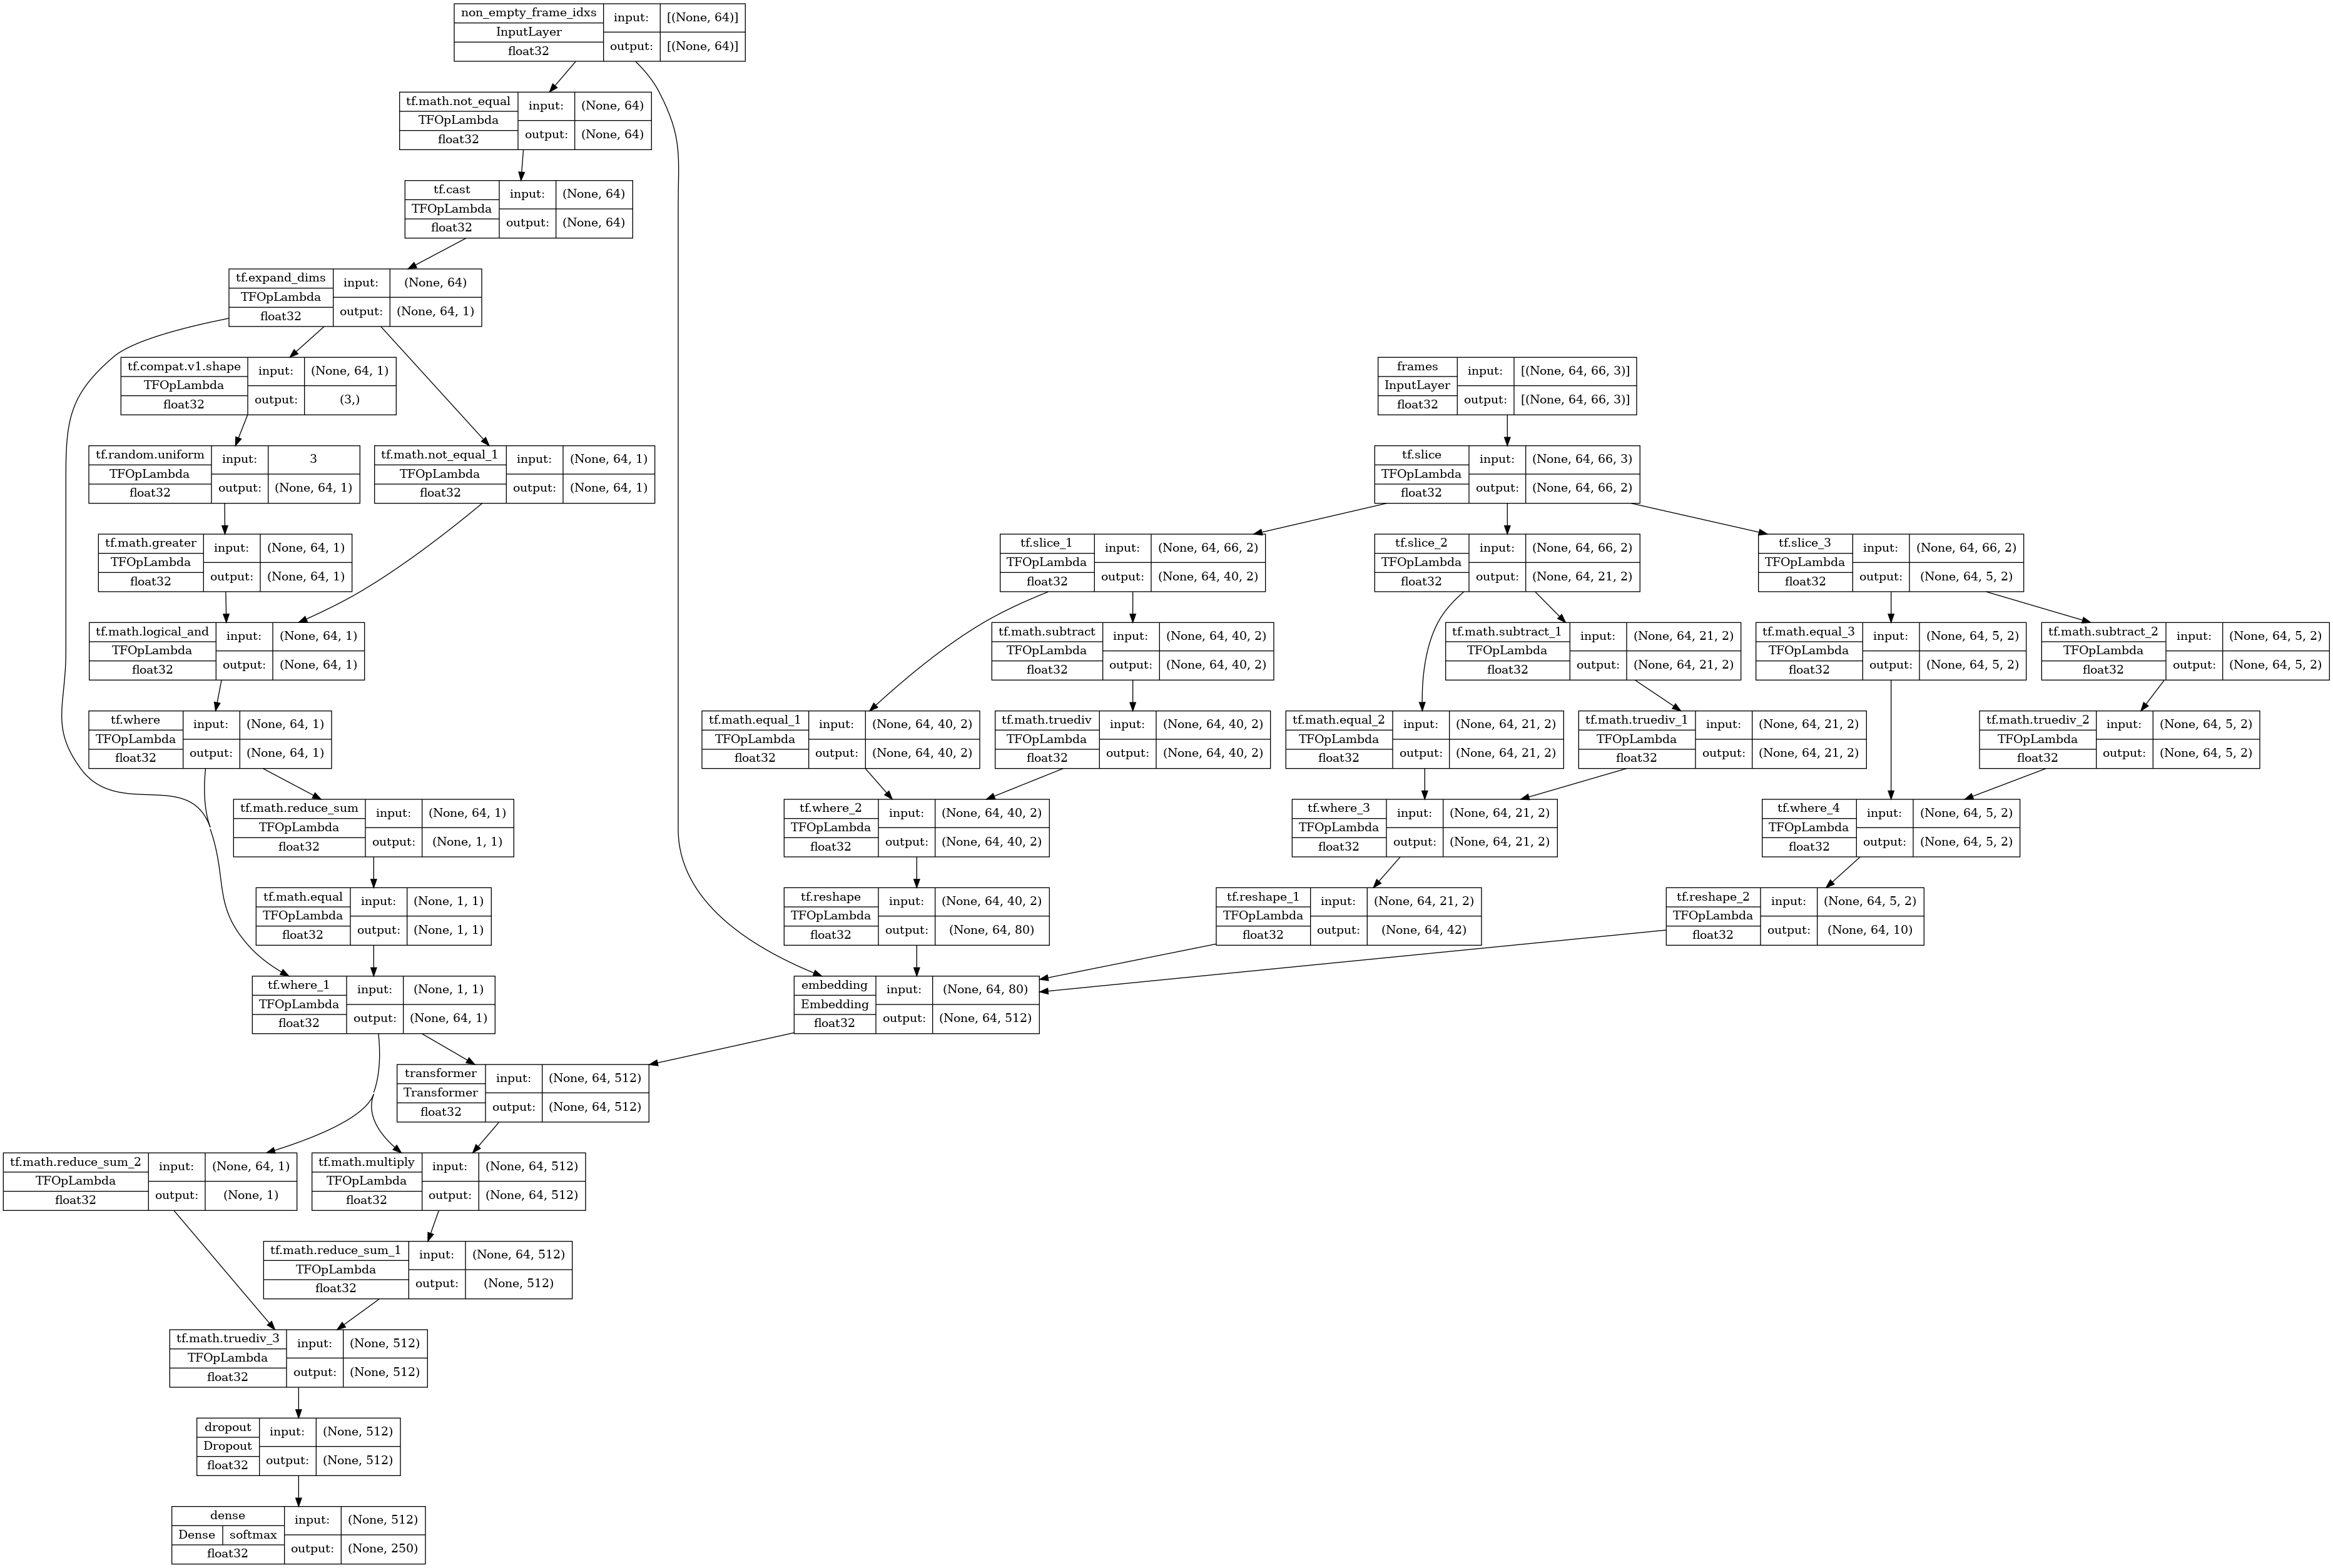

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# No NaN Predictions

In [41]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    y_pred = model.predict_on_batch(X_batch).flatten()

    print(f'# NaN Values In Prediction: {np.isnan(y_pred).sum()}')

# NaN Values In Prediction: 0


# Weight Initialization

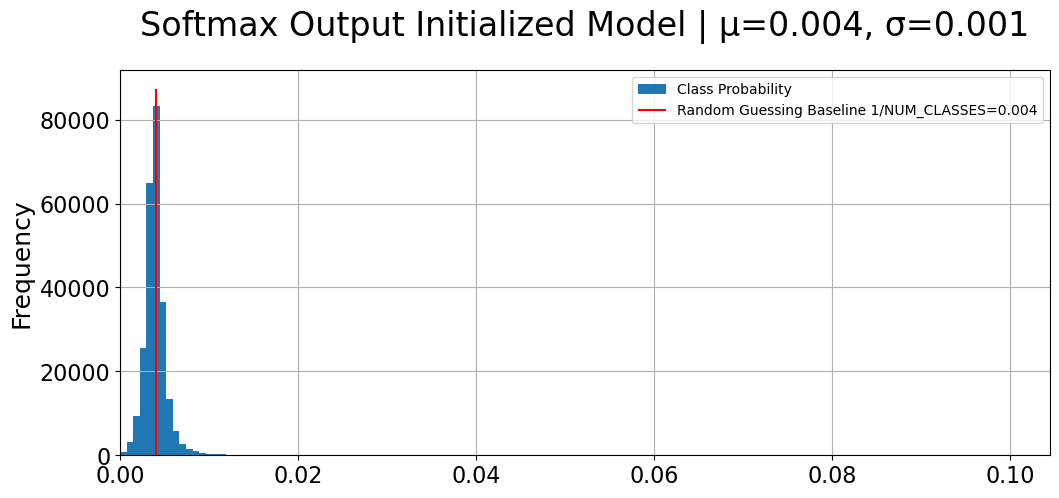

In [42]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    plt.figure(figsize=(12,5))
    plt.title(f'Softmax Output Initialized Model | µ={y_pred.mean():.3f}, σ={y_pred.std():.3f}', pad=25)
    pd.Series(y_pred).plot(kind='hist', bins=128, label='Class Probability')
    plt.xlim(0, max(y_pred) * 1.1)
    plt.vlines([1 / NUM_CLASSES], 0, plt.ylim()[1], color='red', label=f'Random Guessing Baseline 1/NUM_CLASSES={1 / NUM_CLASSES:.3f}')
    plt.grid()
    plt.legend()
    plt.show()

# Learning Rate Scheduler

In [43]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

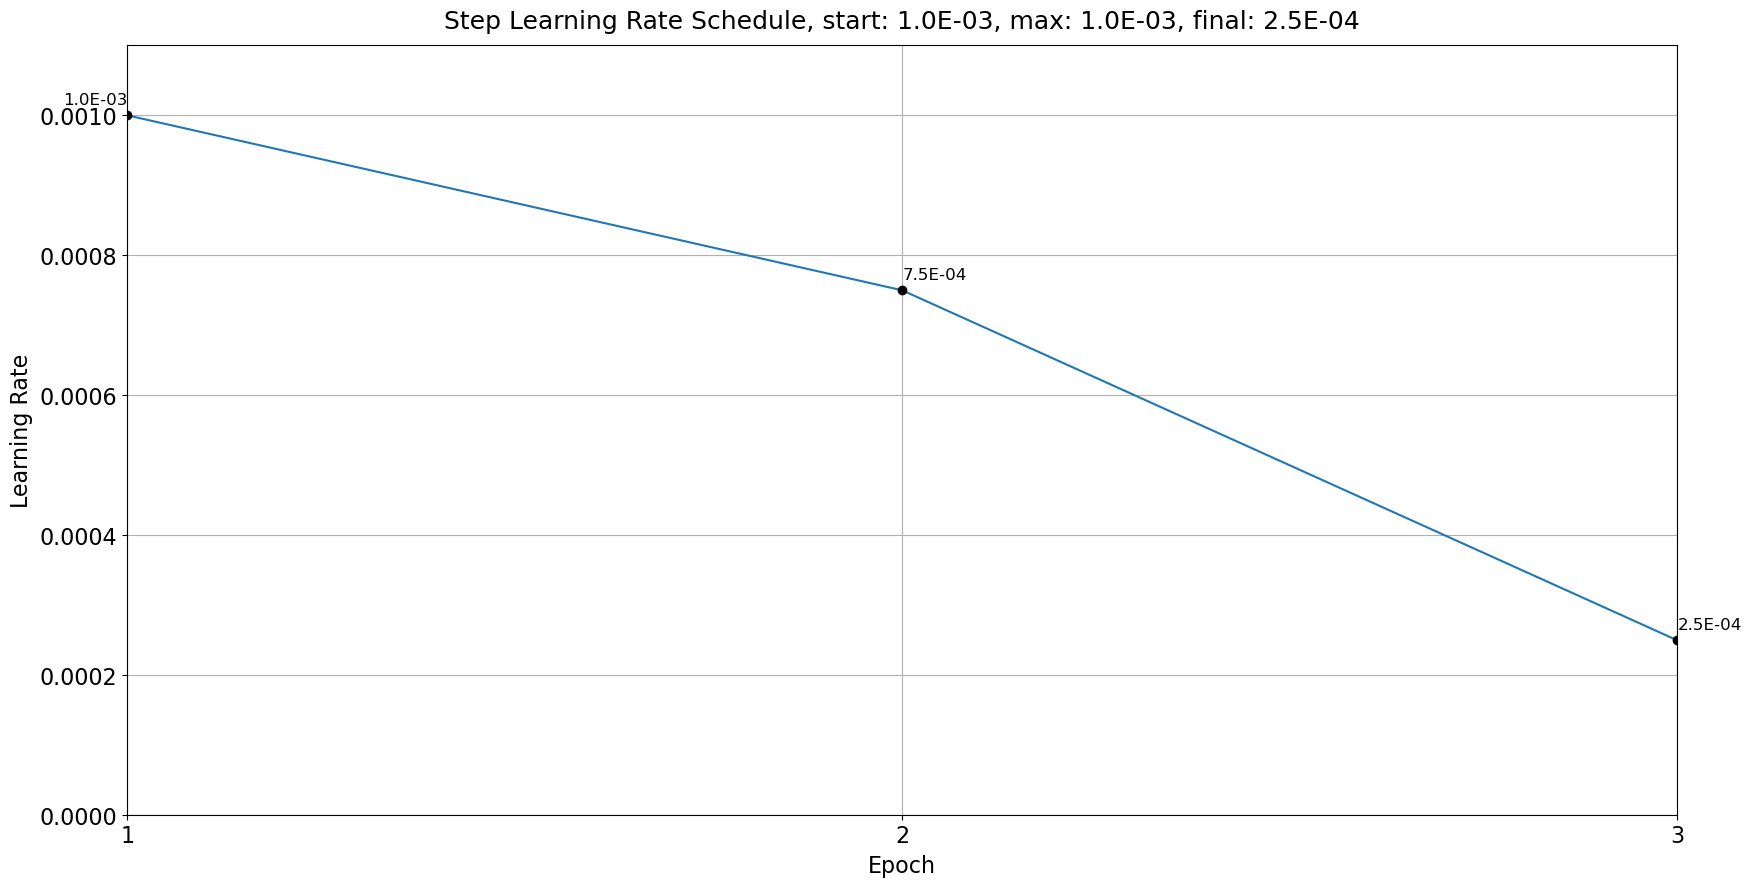

In [44]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Weight Decay Callback

In [45]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Performance Benchmark

In [46]:
%%timeit -n 100
if TRAIN_MODEL:
    # Verify model prediction is <<<100ms
    model.predict_on_batch({ 'frames': X_train[:1], 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TRAIN[:1] })
    pass

18.2 ms ± 5.75 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Training

In [47]:
if USE_VAL:
    # Verify Validation Dataset Covers All Signs
    print(f'# Unique Signs in Validation Set: {pd.Series(y_val).nunique()}')
    # Value Counts
    display(pd.Series(y_val).value_counts().to_frame('Count').iloc[[1,2,3,-3,-2,-1]])

# Unique Signs in Validation Set: 250


,Count
38,67
235,66
172,66
106,43
170,35
249,32


# Evaluate Initialzied Model

In [48]:
label_smooth = 0.25
# Sanity Check
if TRAIN_MODEL and USE_VAL:
    _ = model.evaluate(*validation_data, verbose=2)

446/446 - 9s - loss: 5.5319 - acc: 0.0043 - top_5_acc: 0.0206 - top_10_acc: 0.0396 - 9s/epoch - 20ms/step


# Train

In [49]:
def train_model():
    # Clear all models in GPU
    tf.keras.backend.clear_session()
    
    # Learning rate for encoder
    LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
    # Learning Rate Callback
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)
    
    WeightDecayCallback()
    
    # Get new fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN,n=BATCH_ALL_SIGNS_N),
            steps_per_epoch= len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs= N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = VERBOSE,
        )
    
    return model, history

train_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

(<keras.engine.functional.Functional at 0x77cc614035d0>,
 <keras.callbacks.History at 0x77cc613a64d0>)

# Hyper Parameter Tuning

In [50]:
def train_eval_model1(parameters):
    
    # Clear all models in GPU
    tf.keras.backend.clear_session()
    
    CLASSIFIER_DROPOUT_RATIO = parameters['classifier_dropout']
    MLP_DROPOUT_RATIO =parameters['MLP_dropout']
    
    #Update Learning rate for encoder
    LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
    #Update Learning Rate Callback
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)
    #Update WeightDecay Callback()
    WeightDecayCallback()
    
    # Get new fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN,),
            steps_per_epoch= len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs= N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = VERBOSE,
        )
    
    val_metrics = model.evaluate(*validation_data, verbose=2)
    
    return -val_metrics[1] 

In [51]:
from hyperopt import fmin, tpe, hp
search_space = {'classifier_dropout': hp.uniform('classifier_dropout',0, 0.15),'MLP_dropout':hp.uniform('MLP_dropout',0, 0.3)}

best_params1 = fmin(train_eval_model1, search_space, algo=tpe.suggest, max_evals=3)


Model: "model"                                       

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               

 er)                                                                                              

 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   

 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      

 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']                

 frames (InputLayer)            [(None, 64, 66, 3)]  0           []                               

 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['tf.expand_dims[0][0]']         

 )                                          

In [52]:
best_params1

{'MLP_dropout': 0.19618411210188455, 'classifier_dropout': 0.14415537286402622}

In [53]:
#Setting Hyper Parameters based on Fine Tuning Results
CLASSIFIER_DROPOUT_RATIO = best_params1['classifier_dropout']
MLP_DROPOUT_RATIO = best_params1['MLP_dropout']

In [56]:
def train_eval_model2(parameters):
    
    # Clear all models in GPU
    tf.keras.backend.clear_session()
    
    
    label_smooth = parameters['label_smooth']
    LR_MAX = parameters['lr_max']
    
    #Update Learning rate for encoder
    LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
    #Update Learning Rate Callback
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)
    #Update WeightDecay Callback()
    WeightDecayCallback()
    
    
    # Get new fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
            steps_per_epoch= len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs= N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = VERBOSE,
        )
    
    val_metrics = model.evaluate(*validation_data, verbose=2)
    
    return -val_metrics[1] 

In [57]:
search_space = {'label_smooth': hp.uniform('label_smooth',0, 0.25), 'lr_max': hp.uniform('lr_max', 1e-3, 1e-2)}
best_params2 = fmin(train_eval_model2, search_space, algo=tpe.suggest, max_evals=3)

Model: "model"                                       

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               

 er)                                                                                              

 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   

 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      

 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']                

 frames (InputLayer)            [(None, 64, 66, 3)]  0           []                               

 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['tf.expand_dims[0][0]']         

 )                                          

In [58]:
best_params2

{'label_smooth': 0.07883101828622435, 'lr_max': 0.001834166680272955}

In [59]:
#Setting Hyper Parameters based on Fine Tuning Results
label_smooth = best_params2['label_smooth']
LR_MAX = best_params2['lr_max']

# Final Training

In [60]:
#Increase the N_Epoch and Number of Each Signs in our training data

BATCH_ALL_SIGNS_N = 7
N_EPOCHS = 30

In [61]:
#Get New Batch Data
dummy_dataset = get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, n=BATCH_ALL_SIGNS_N)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (1750, 64, 66, 3), dtype: float32
non_empty_frame_idxs shape: (1750, 64), dtype: float32
y_batch shape: (1750,), dtype: int64


,Counts
0,7
171,7
158,7
159,7
160,7
...,...
88,7
89,7
90,7
91,7


In [62]:
model, history = train_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

In [63]:
# Save Model Weights
model.save_weights('final_model.h5')

In [64]:
val_metrics = model.evaluate(*validation_data, verbose=2)

446/446 - 7s - loss: 1.9365 - acc: 0.6922 - top_5_acc: 0.8895 - top_10_acc: 0.9262 - 7s/epoch - 15ms/step


In [65]:
if USE_VAL:
    # Validation Predictions
    y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
    # Label
    labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

446/446 - 8s - 8s/epoch - 17ms/step


# Landmark Attention Weights

In [66]:
# Landmark Weights
for w in model.get_layer('embedding').weights:
    if 'landmark_weights' in w.name:
        weights = scipy.special.softmax(w)

landmarks = ['lips_embedding', 'left_hand_embedding', 'pose_embedding']

for w, lm in zip(weights, landmarks):
    print(f'{lm} weight: {(w*100):.1f}%')

lips_embedding weight: 29.4%
left_hand_embedding weight: 42.5%
pose_embedding weight: 28.1%


# Classification Report

In [67]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [68]:
if USE_VAL:
    print_classification_report()

,precision,recall,f1-score,support,sign,sign_ord
frog,0.98,0.98,0.98,54,frog,90
cow,0.94,1.00,0.97,60,cow,50
doll,0.98,0.93,0.96,61,doll,59
donkey,1.00,0.90,0.95,59,donkey,60
airplane,0.93,0.96,0.95,57,airplane,2
gum,0.92,0.97,0.94,59,gum,103
horse,0.91,0.98,0.94,60,horse,119
owl,0.96,0.91,0.94,57,owl,165
uncle,0.93,0.93,0.93,60,uncle,228
lion,0.94,0.89,0.92,55,lion,133


# Training History

In [69]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

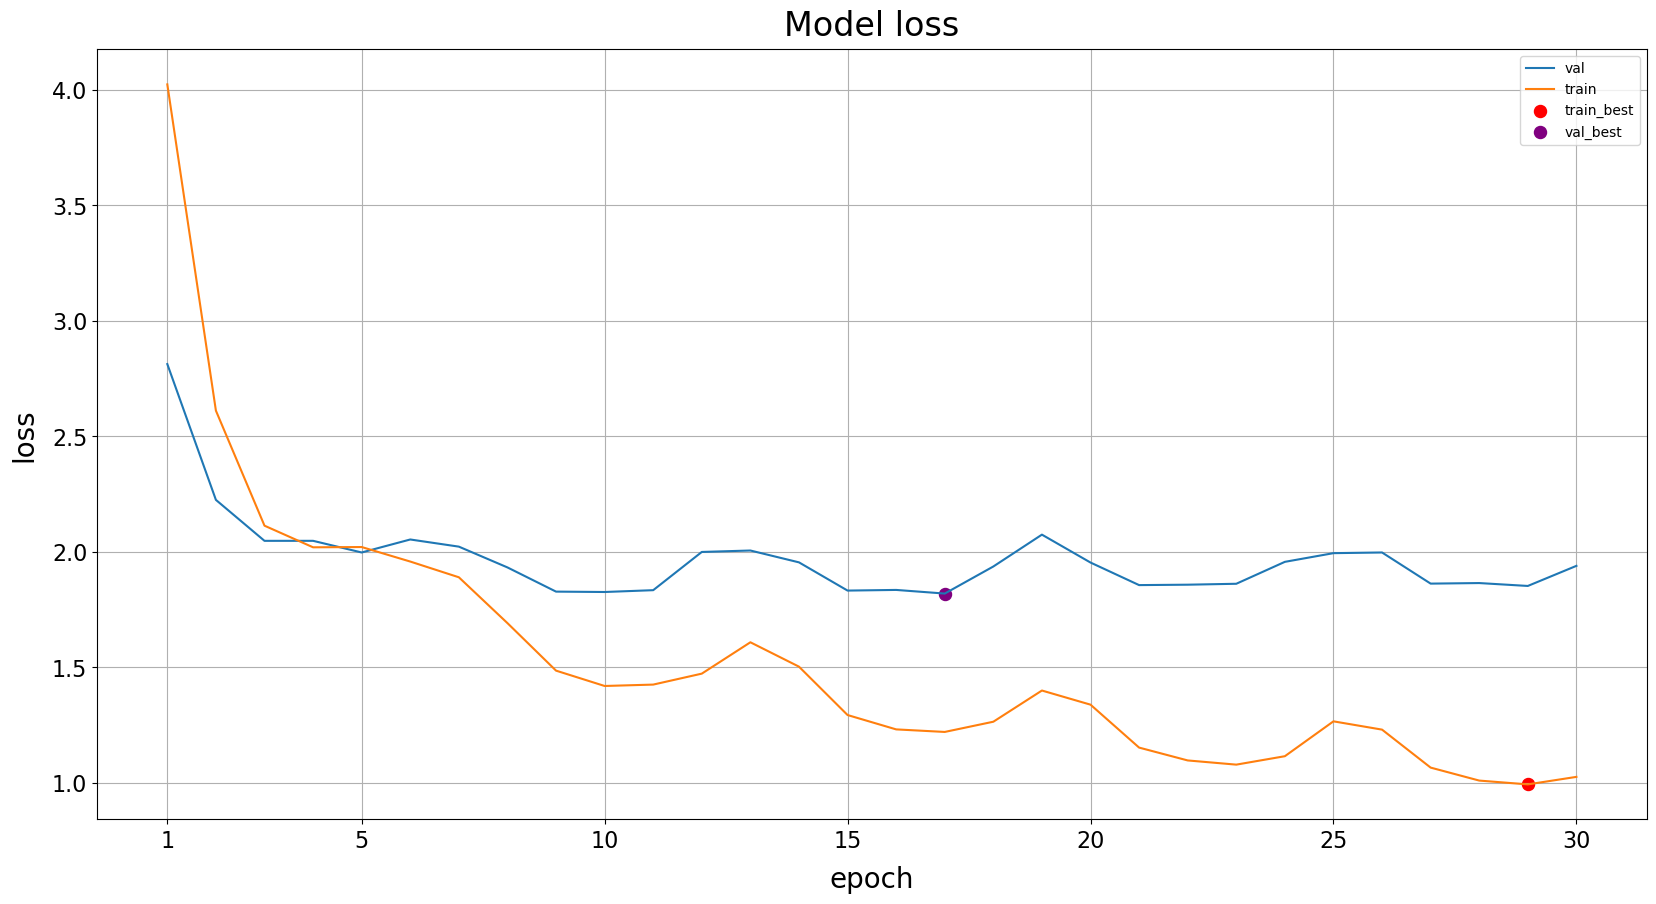

In [70]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

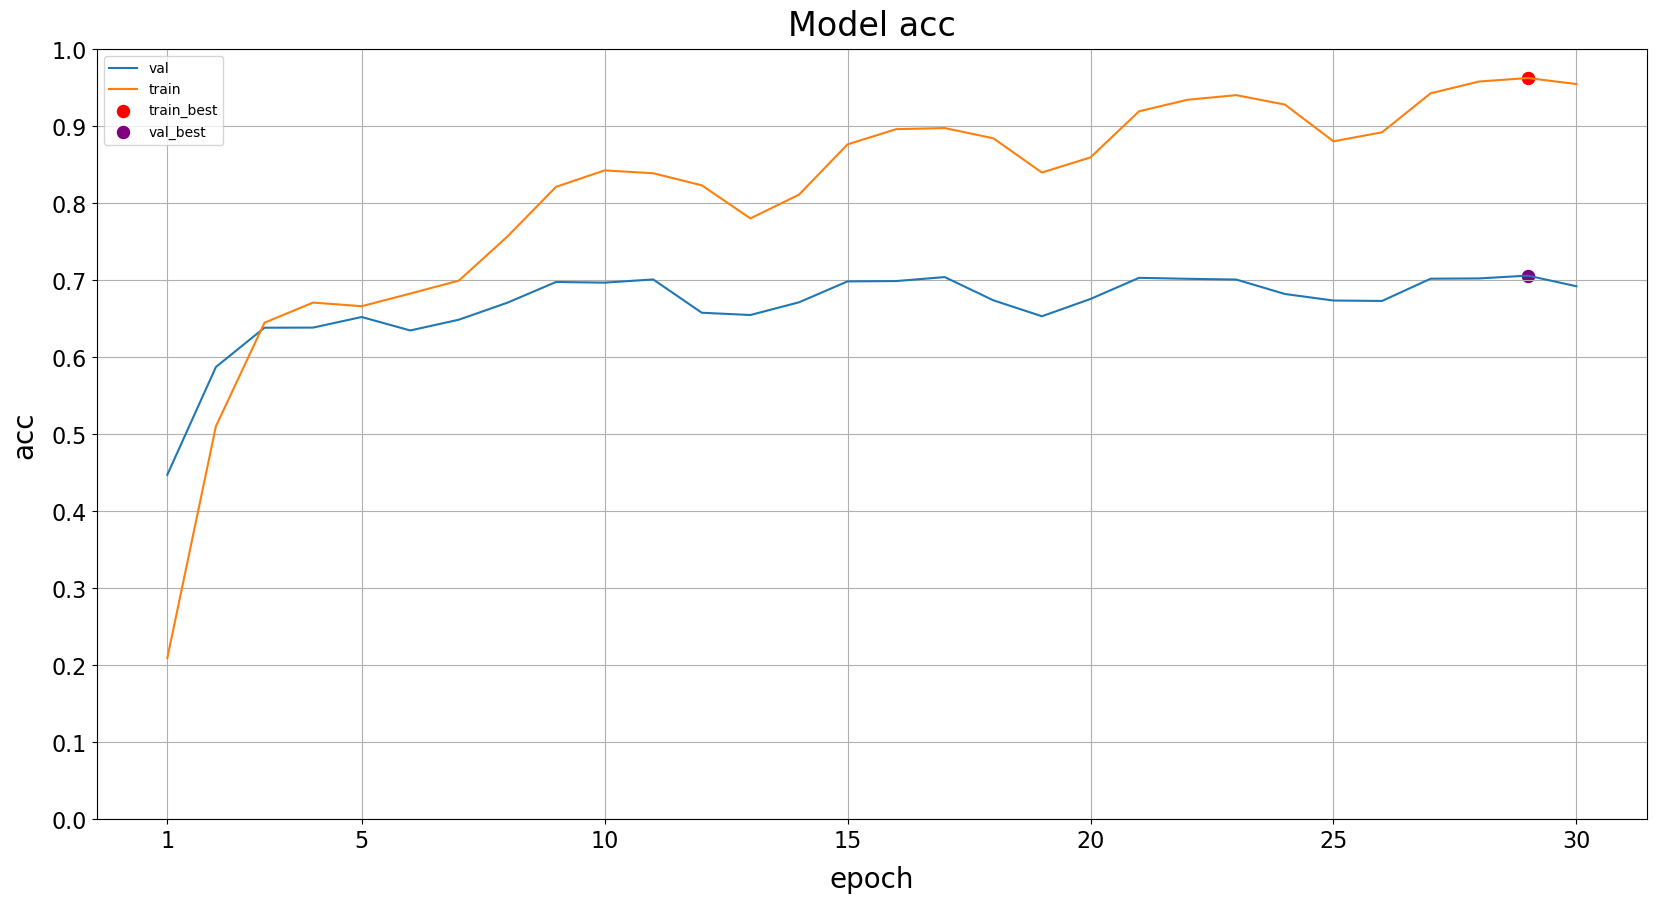

In [71]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

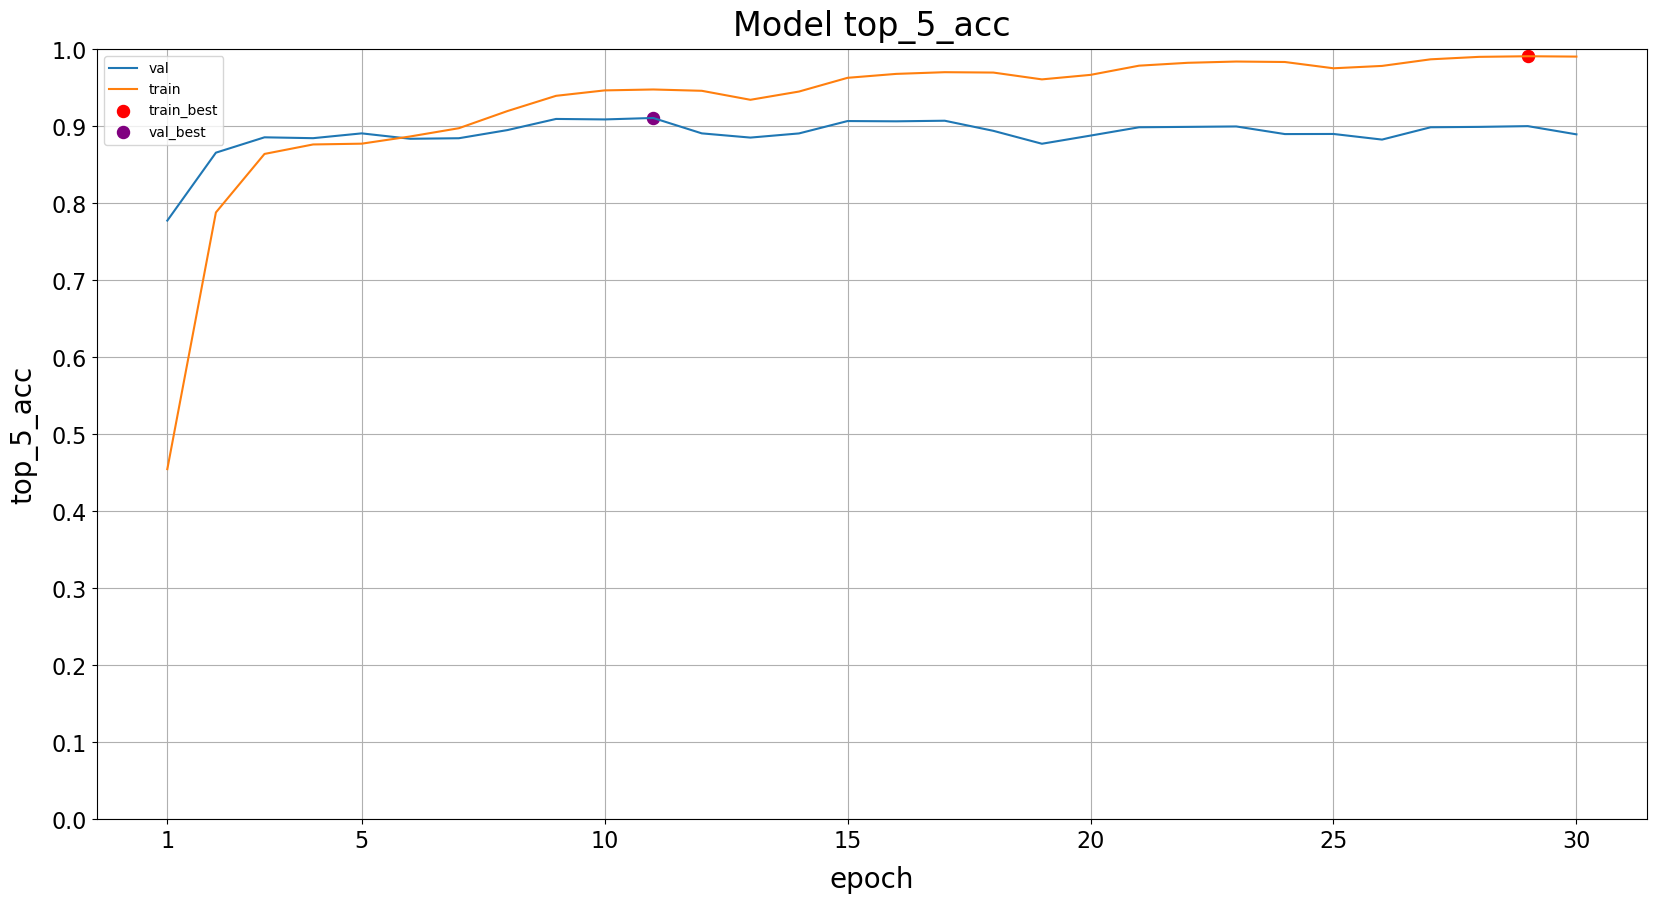

In [72]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

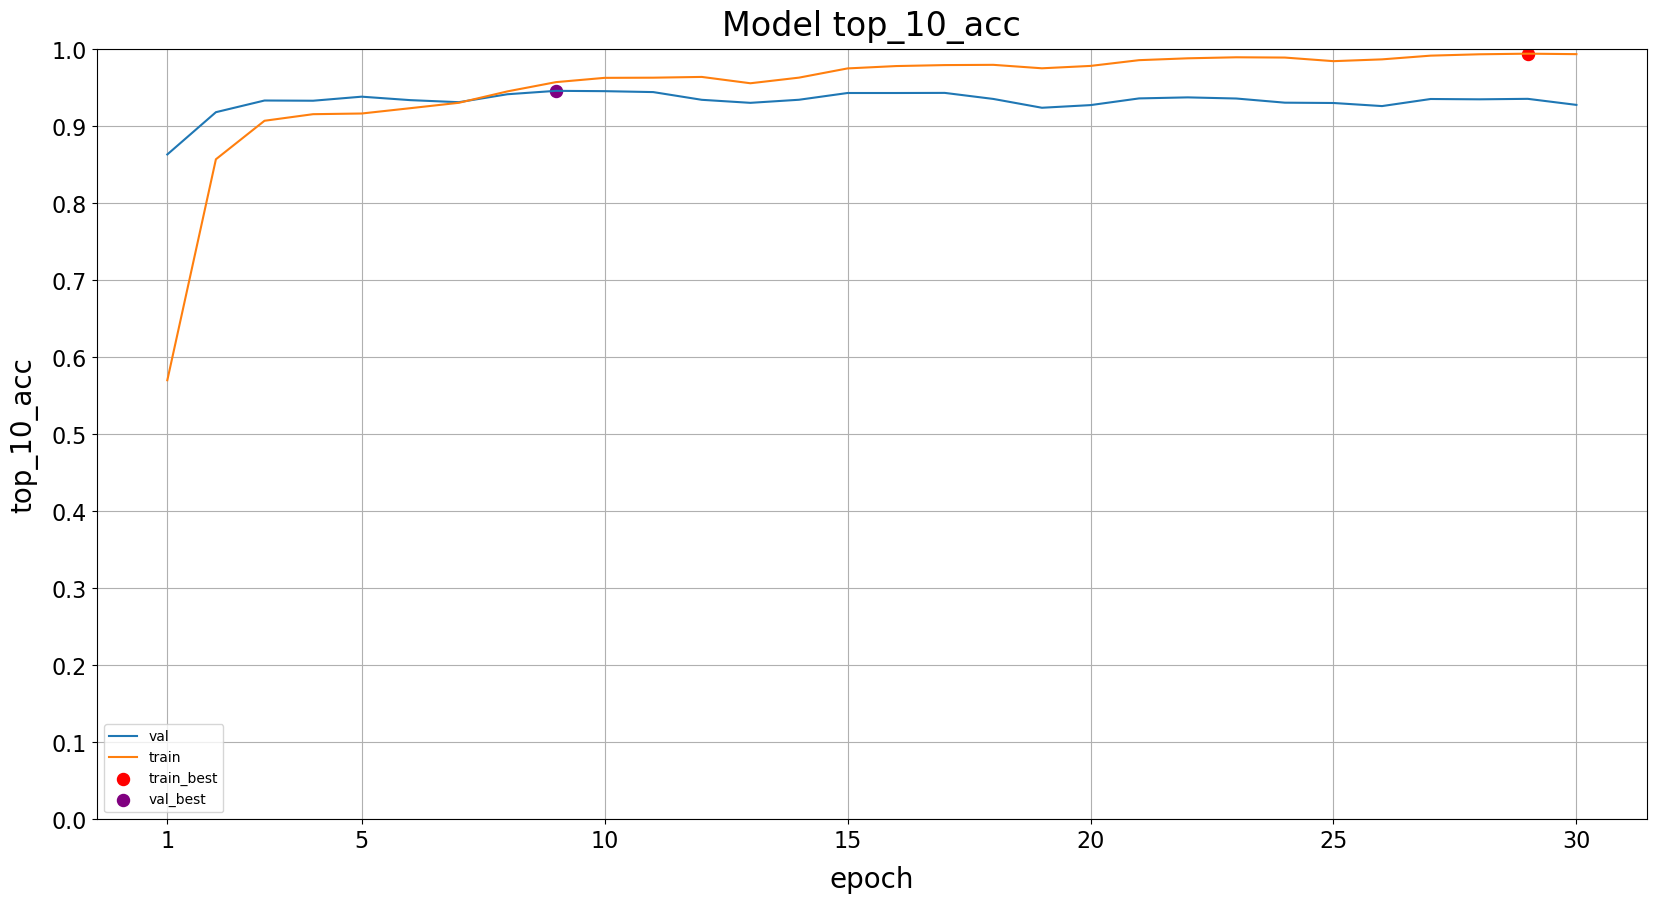

In [73]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

In [74]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)


In [75]:
# Sanity Check
demo_raw_data = load_relevant_data_subset(train['file_path'].values[0])
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)["outputs"]
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

demo_raw_data shape: (11, 543, 3), dtype: float32
demo_output shape: (250,), dtype: <dtype: 'float32'>
demo_prediction: 159, correct: 159


In [78]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Zip Model
!zip submission.zip /kaggle/working/model.tflite

  adding: kaggle/working/model.tflite (deflated 8%)


In [79]:
# Verify TFLite model can be loaded and used for prediction
!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=demo_raw_data)
sign = output['outputs'].argmax()

print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
print("TRUE : ", train.sign.values[0], f'[{train.sign_ord.values[0]}]')

PRED :  old [159]
TRUE :  old [159]
